In [108]:
using PyPlot

# Prox of nonnegative regularizer

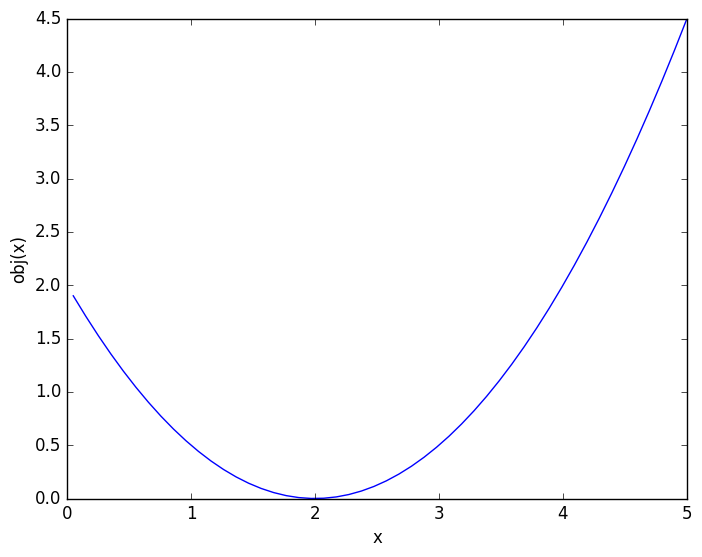

PyObject <matplotlib.text.Text object at 0x330da01d0>

In [109]:
# prox of nonneg minimizes I(x>=0) + 1/2(x-z)^2
z = 2
x = linspace(-5, 5, 100)
objx = [xi<0?Inf:0 + 1/2*(xi-z)^2 for xi in x]
plot(x, objx)
xlabel("x")
ylabel("obj(x)")

In [110]:
prox_nonneg(x) = max(0,x)

x = randn(2)
x /= norm(x)
px = prox_nonneg(x)

2-element Array{Float64,1}:
 0.943719
 0.330748

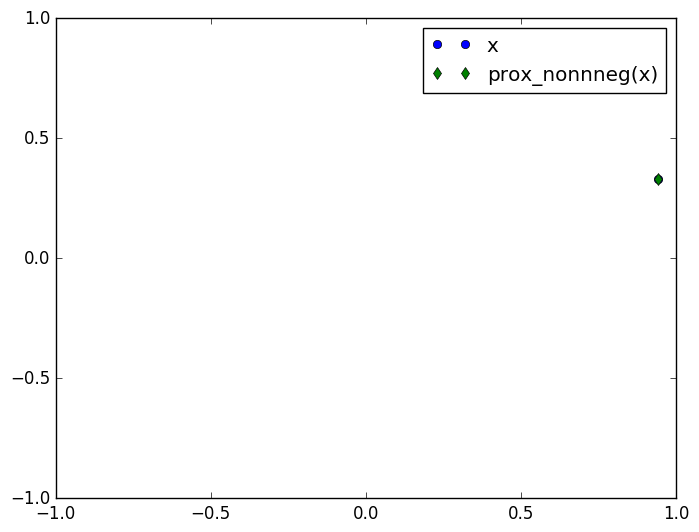

PyObject <matplotlib.legend.Legend object at 0x3311a8290>

In [111]:
plot(x[1],x[2],"o",label="x")
plot(px[1],px[2],"d",label="prox_nonnneg(x)")
xlim([-1,1])
ylim([-1,1])
legend()

# Prox of l1 regularizer

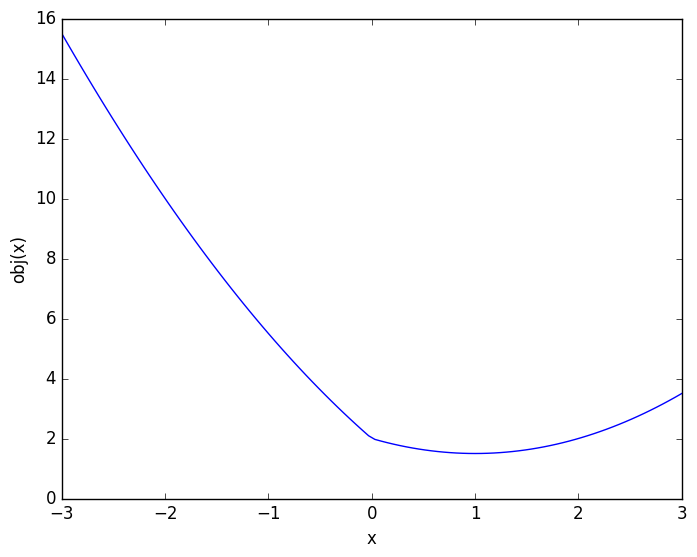

PyObject <matplotlib.text.Text object at 0x3311f1e90>

In [112]:
# prox of l1 minimizes |x| + 1/2(x-z)^2
z = 2
x = linspace(-3, 3, 100)
objx = [abs(xi) + 1/2*(xi-z)^2 for xi in x]
plot(x, objx)
xlabel("x")
ylabel("obj(x)")

In [113]:
function prox_l1(x::Number, alpha=1)
    if x > alpha
        return x-alpha
    elseif x < -alpha
        return x + alpha
    else
        return 0
    end
end
function prox_l1(x::AbstractArray, alpha=1)
    return reshape(Float64[prox_l1(xi, alpha) for xi in x], size(x))
end

prox_l1 (generic function with 4 methods)

In [114]:
@show x = randn()
@show px = prox_l1(x);

x = randn() = 0.5846035014930245
px = prox_l1(x) = 0


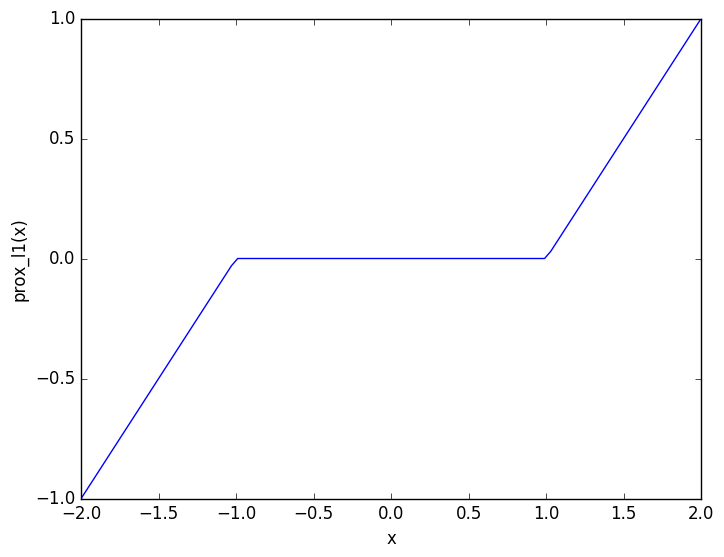

PyObject <matplotlib.text.Text object at 0x331413110>

In [115]:
x = linspace(-2, 2, 100)
px = [prox_l1(xi) for xi in x]
plot(x, px)
xlabel("x")
ylabel("prox_l1(x)")

In [116]:
@show x = randn(2)
@show px = prox_l1(x);

x = randn(2) = [0.508648,0.255602]
px = prox_l1(x) = [0.0,0.0]


# proximal gradient method

$$\nabla \|Xw-y\|^2 = \nabla((Xw-y)^T (Xw-y)) = 2X^T(Xw-y)$$

In [117]:
# proximal gradient method for quadratic loss and nonnegative regularizer
function proxgrad_quad_nonneg(X, y; maxiters = 10, stepsize = 1, w = zeros(size(X,2)))
    w = zeros(size(X,2))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = 2X'*(X*w-y) # compute quadratic gradient
        w = w - stepsize*g
        # prox step
        w = prox_nonneg(w)
        # record objective value
        push!(objval, norm(X*w-y)^2 + any(w<0) ? Inf : 0)
    end
    return w, objval
end

proxgrad_quad_nonneg (generic function with 1 method)

In [118]:
# proximal gradient method for quadratic loss and l1 regularizer
function proxgrad_quad_l1(X, y; maxiters = 10, stepsize = 1, λ = 1, w = zeros(size(X,2)))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = 2X'*(X*w-y) # compute quadratic gradient
        w = w - stepsize*g
        # prox step
        w = prox_l1(w, stepsize*λ)
        # record objective value
        push!(objval, norm(X*w-y)^2 + norm(w,1))
    end
    return w, objval
end

proxgrad_quad_l1 (generic function with 1 method)

let's solve the problem $$\text{minimize} \quad (y-w)^2 + |w|$$

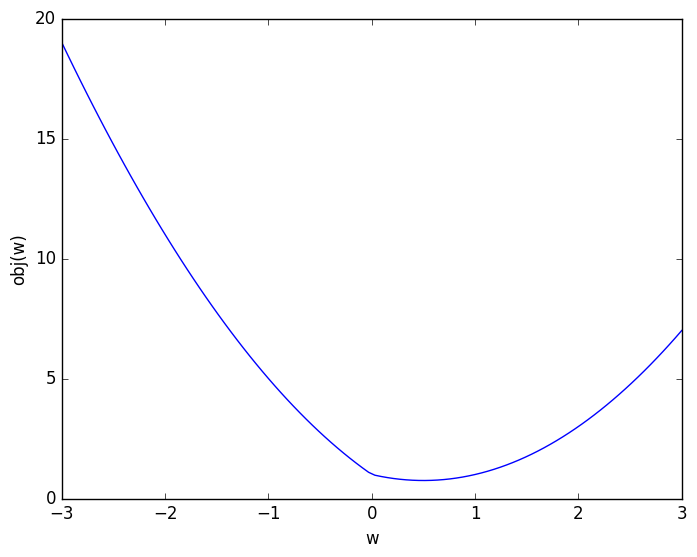

PyObject <matplotlib.text.Text object at 0x331413d90>

In [119]:
y = 1
wvec = linspace(-3, 3, 100)
objwvec = [(wi-y)^2 + abs(wi) for wi in wvec]
plot(wvec, objwvec)
xlabel("w")
ylabel("obj(w)")

In [139]:
w = -2

-2

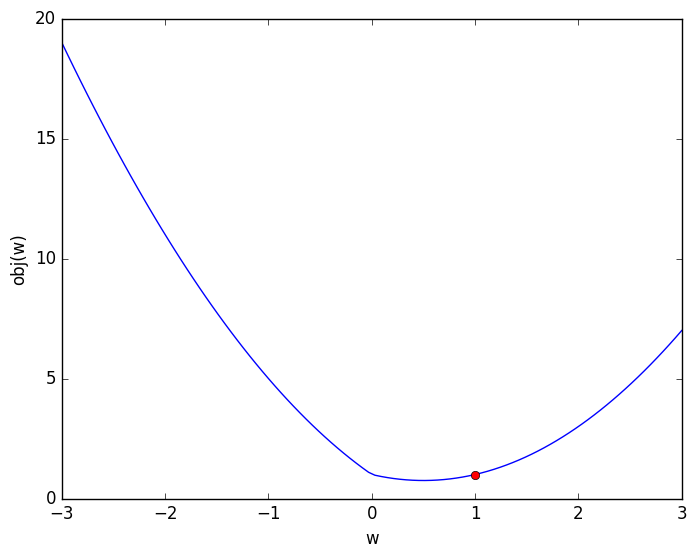

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x334f13890>

In [146]:
w, obj = proxgrad_quad_l1(ones(1,1), ones(1); maxiters = 1, stepsize = 1, w = w)

plot(wvec, objwvec)
xlabel("w")
ylabel("obj(w)")
plot(w, obj[end], "ro")

# Introduce LowRankModels

In [15]:
using LowRankModels

In [16]:
# loss function
loss = QuadLoss()

LowRankModels.QuadLoss(1.0,LowRankModels.RealDomain())

In [17]:
# regularizers
lambda = 1

nonneg = NonNegConstraint()
l1 = OneReg(lambda)
l2 = QuadReg(lambda)

LowRankModels.QuadReg(1.0)

In [18]:
# the quad loss returns the sum of square differences between its first and second argument
evaluate(loss, 2., 3.)

1.0

In [19]:
evaluate(3*loss, 2., 3.)

3.0

In [20]:
evaluate(loss, [2., 2.], [3., 3.])

2.0

In [21]:
# can also evaluate the gradient wrt the first argument
grad(loss, 2., 0.)

4.0

In [22]:
grad(loss, 0., 2.)

-4.0

In [23]:
# can evaluate the proximal operator of the regularizer
prox(nonneg, 1)

1

In [24]:
# can evaluate the proximal operator of lambda times the regularizer
λ = .1
prox(l1, 1, λ)

0.9

In [25]:
λ = .01
prox(l1, 1, λ)

0.99

In [26]:
# chain rule: 
# gradient of ||Xw - y||^2 wrt w is X' * <gradient of ||z-y||^2 wrt z>, 
# where z = X*w

In [27]:
import LowRankModels: evaluate, grad
evaluate(loss::Loss, X::Array{Float64,2}, w, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w, y) = X'*grad(loss, X*w, y)

grad (generic function with 13 methods)

In [28]:
# proximal gradient method
function proxgrad(loss, reg, X, y; maxiters = 10, stepsize = 1)
    w = zeros(size(X,2))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = grad(loss, X, w, y)
        w = w - stepsize*g
        # prox step
        w = prox(reg, w, stepsize)
        # record objective value
        push!(objval, evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w, objval
end

proxgrad (generic function with 1 method)

In [29]:
# proximal gradient method
function proxgrad(loss::Loss, reg::Regularizer, X, y;
                  maxiters::Int = 10, stepsize::Number = 1., 
                  ch::ConvergenceHistory = ConvergenceHistory("proxgrad"))
    w = zeros(size(X,2))
    for t=1:maxiters
        t0 = time()
        # gradient step
        g = grad(loss, X, w, y)
        w = w - stepsize*g
        # prox step
        w = prox(reg, w, stepsize)
        # record objective value
        update_ch!(ch, time() - t0, obj = evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w
end

proxgrad (generic function with 2 methods)

In [46]:
srand(0)
X, y = rand(6,3), rand(6);

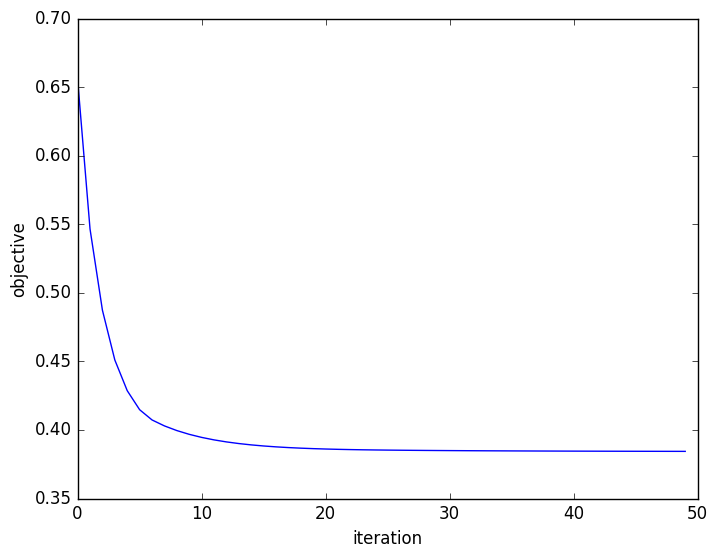

PyObject <matplotlib.text.Text object at 0x32c9548d0>

In [47]:
ch = ConvergenceHistory("NNLS")
w = proxgrad(QuadLoss(), NonNegConstraint(), X, y; 
             stepsize=.1, maxiters=50,
             ch = ch)

plot(ch.objective)
xlabel("iteration")
ylabel("objective")

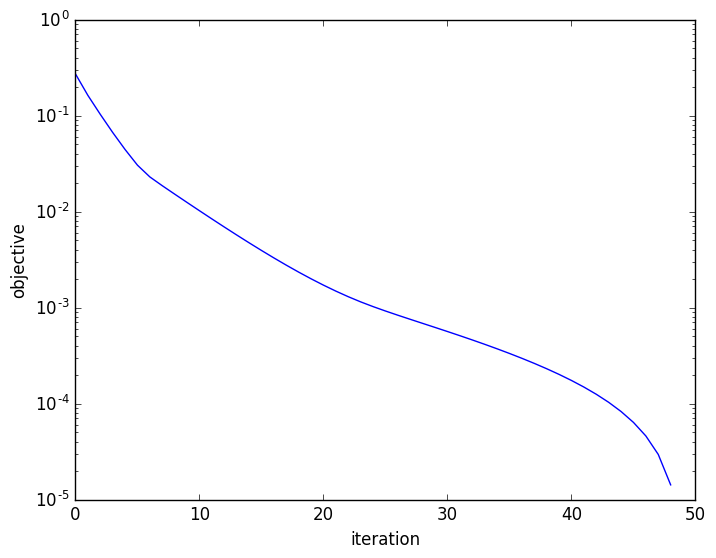

PyObject <matplotlib.text.Text object at 0x32d165250>

In [49]:
semilogy(ch.objective - ch.objective[end])
xlabel("iteration")
ylabel("objective")

# Let's generate some more data and test out these models

In [50]:
function generate_data(n, w)
    X = randn(n,length(w))
    y = X*w
    return X, y
end

function generate_noisy_data(n, w)
    X = randn(n,length(w))
    y = X*w + .1*randn(n)
    return X, y
end

generate_noisy_data (generic function with 1 method)

# let's compare different kinds of regularized regression

In [54]:
function ridge_regression(X,y; λ=1, kwargs...)
    w = proxgrad(QuadLoss(), λ*QuadReg(), X, y; kwargs...)
    return w
end

ridge_regression (generic function with 1 method)

In [55]:
function nnls(X,y; kwargs...)
    w = proxgrad(QuadLoss(), NonNegConstraint(), X, y; kwargs...)
    return w
end

nnls (generic function with 1 method)

In [64]:
function lasso(X,y; λ=1, kwargs...)
    w = proxgrad(QuadLoss(), λ*OneReg(), X, y; kwargs...)
    return w
end

lasso (generic function with 1 method)

In [97]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = sprandn(d, .5)
w_pos = sprand(d, .5);

w = w_pos

X, y = generate_noisy_data(30, w)

(
[1.7464 -0.381796 … -0.114924 -0.557525; -0.719177 -0.716251 … 1.2656 -0.144004; … ; 0.532887 -1.48004 … 0.855733 0.775359; 0.287327 -0.692182 … -0.247179 -1.06808],

[-0.69702,0.262762,0.514079,-0.980715,-2.37452,2.90754,-0.718837,-1.61493,5.58318,-0.681721  …  3.49165,-0.727965,-2.63774,0.85851,1.29543,2.17672,-0.412429,2.18105,1.92559,0.529847])

In [100]:
maxiters = 100
stepsize = .01/norm(X)

w_ridge = ridge_regression(X,y, maxiters=maxiters, stepsize=stepsize)
w_nonneg = nnls(X,y, maxiters=maxiters, stepsize=stepsize)
w_lasso = lasso(X,y, maxiters=maxiters, stepsize=stepsize);

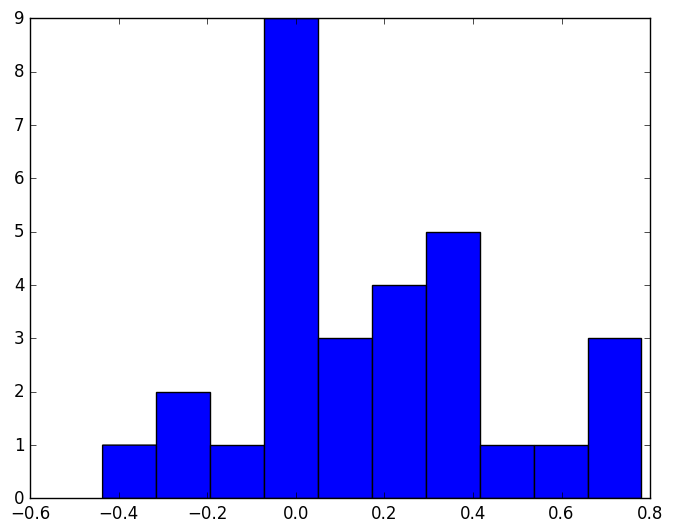

([1.0,2.0,1.0,9.0,3.0,4.0,5.0,1.0,1.0,3.0],[-0.436478,-0.314801,-0.193124,-0.071447,0.0502302,0.171907,0.293584,0.415262,0.536939,0.658616,0.780293],Any[PyObject <matplotlib.patches.Rectangle object at 0x3300cee10>,PyObject <matplotlib.patches.Rectangle object at 0x3300db4d0>,PyObject <matplotlib.patches.Rectangle object at 0x3300dbb50>,PyObject <matplotlib.patches.Rectangle object at 0x3300e9210>,PyObject <matplotlib.patches.Rectangle object at 0x3300e9890>,PyObject <matplotlib.patches.Rectangle object at 0x3300e9f10>,PyObject <matplotlib.patches.Rectangle object at 0x3300f55d0>,PyObject <matplotlib.patches.Rectangle object at 0x3300f5c50>,PyObject <matplotlib.patches.Rectangle object at 0x330102310>,PyObject <matplotlib.patches.Rectangle object at 0x330102990>])

In [101]:
plt[:hist](w_ridge)

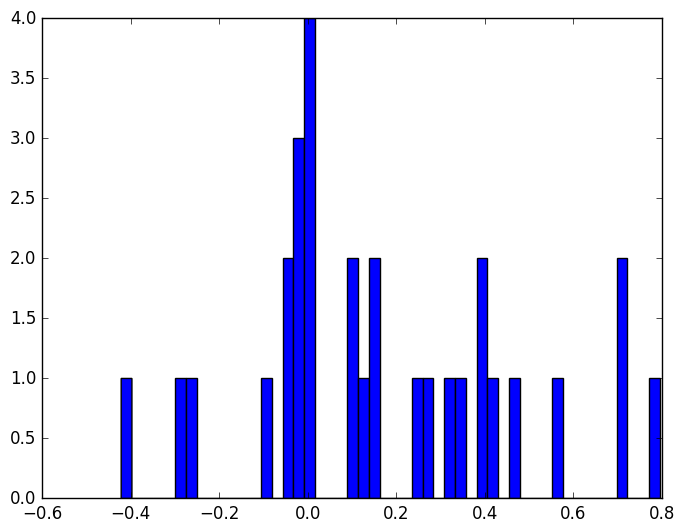

([1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0  …  1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0],[-0.421359,-0.397042,-0.372725,-0.348408,-0.324092,-0.299775,-0.275458,-0.251142,-0.226825,-0.202508  …  0.575626,0.599943,0.62426,0.648577,0.672893,0.69721,0.721527,0.745843,0.77016,0.794477],Any[PyObject <matplotlib.patches.Rectangle object at 0x3303338d0>,PyObject <matplotlib.patches.Rectangle object at 0x330333f50>,PyObject <matplotlib.patches.Rectangle object at 0x330340610>,PyObject <matplotlib.patches.Rectangle object at 0x330340c90>,PyObject <matplotlib.patches.Rectangle object at 0x33034e350>,PyObject <matplotlib.patches.Rectangle object at 0x33034e9d0>,PyObject <matplotlib.patches.Rectangle object at 0x33034eed0>,PyObject <matplotlib.patches.Rectangle object at 0x33035a710>,PyObject <matplotlib.patches.Rectangle object at 0x33035ad90>,PyObject <matplotlib.patches.Rectangle object at 0x330369450>  …  PyObject <matplotlib.patches.Rectangle object at 0x3303fce50>,PyObject <matplotlib.patches.R

In [102]:
plt[:hist](w_lasso, bins=50)

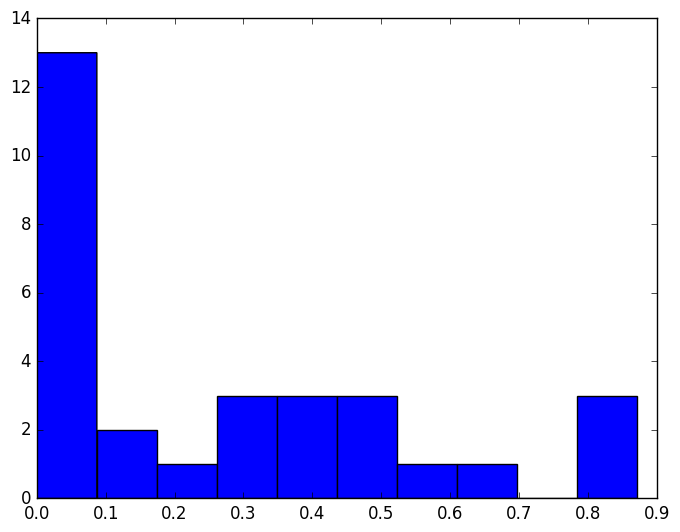

([13.0,2.0,1.0,3.0,3.0,3.0,1.0,1.0,0.0,3.0],[0.0,0.0871879,0.174376,0.261564,0.348751,0.435939,0.523127,0.610315,0.697503,0.784691,0.871879],Any[PyObject <matplotlib.patches.Rectangle object at 0x330677850>,PyObject <matplotlib.patches.Rectangle object at 0x330677ed0>,PyObject <matplotlib.patches.Rectangle object at 0x330684590>,PyObject <matplotlib.patches.Rectangle object at 0x330684c10>,PyObject <matplotlib.patches.Rectangle object at 0x3306902d0>,PyObject <matplotlib.patches.Rectangle object at 0x330690950>,PyObject <matplotlib.patches.Rectangle object at 0x330690fd0>,PyObject <matplotlib.patches.Rectangle object at 0x33069e690>,PyObject <matplotlib.patches.Rectangle object at 0x33069ed10>,PyObject <matplotlib.patches.Rectangle object at 0x3306ac3d0>])

In [103]:
plt[:hist](w_nonneg)

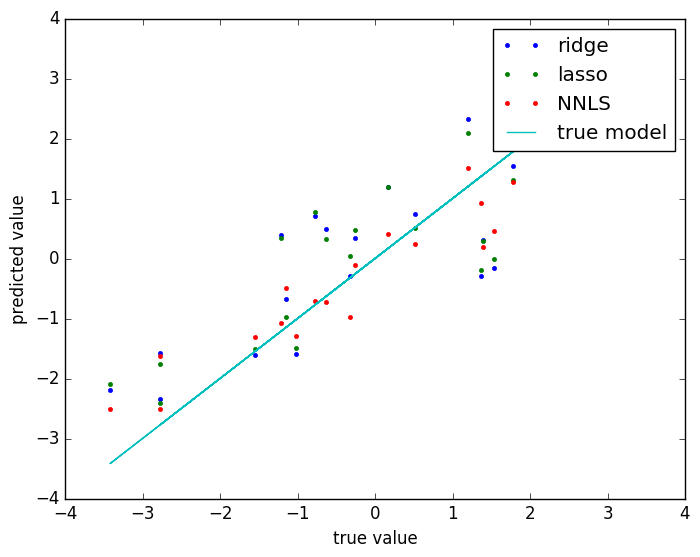

PyObject <matplotlib.text.Text object at 0x3306ac550>

In [104]:
# which fits data best?
Xtest,ytest = generate_data(20,w)

plot(ytest,Xtest*w_ridge,label="ridge",".")
plot(ytest,Xtest*w_lasso,label="lasso",".")
plot(ytest,Xtest*w_nonneg,label="NNLS",".")
plot(ytest,ytest,label="true model")
legend()
xlabel("true value")
ylabel("predicted value")

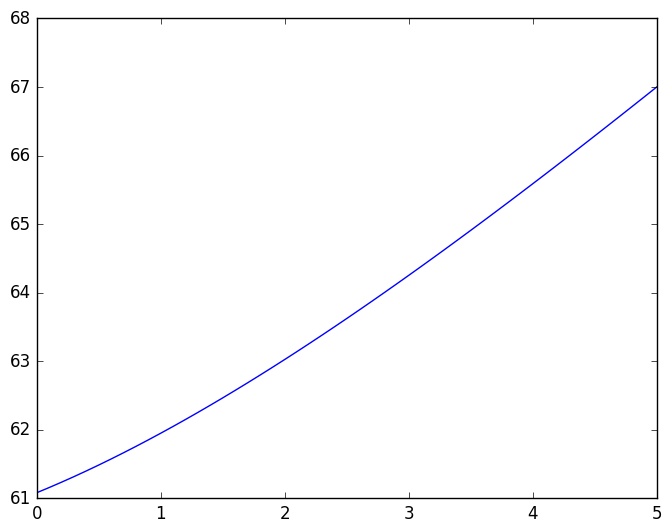

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x330d44f10>

In [106]:
# cross validate over lambda

w = .5*randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

error = Float64[]
λs = 0:.1:5
for λ in λs
    w = ridge_regression(X,y; λ=λ, maxiters=maxiters, stepsize=stepsize)
    push!(error, sum((ytest - Xtest*w).^2))
end
plot(λs, error)